# Import libraries

In [1]:
import pandas as pd
import numpy as np
#
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Prediction visualisation
import matplotlib.cm as cm # Used later on, has to be included in codeblock where it is used due to same name of fucntions in other packages
import matplotlib.pyplot as plt



# Tree Visualisation

import os
from sklearn.tree import export_graphviz

from subprocess import call
from IPython.display import Image


# !!! make sure that the files are in the same folder

# This imports the data_prep.py file that contains the current version of the data prep files. Currently this only contains the neighebour extraction
import data_prep

In [11]:
# so far the Game of Life = GoL, does not save to csv if executed from command below. Has to be executed from command line anaconda prompt. This is why here I manually adjust the grid-size parameter for GameofLife
GoL_grid_size = 20
maxframes = 100
timesteps = maxframes

In [ ]:
# %run Game_of_Life.py --interval 100 --grid-size 5 --writetocsv --maxframes 3
%run Game_of_Life.py --interval 10 --grid-size 20 --writetocsv --maxframes 20

# Get the data from the model and check if it makes sense

Only demand I have for the model output is that it is structured as follows:
- All pixels are flattened into an array
  - The pixels of the next time step are ammended to this array
- It should have an attribute that returns the number of pixels used in the simulation
- The software currently has issues with missing numbers of non - rectangular grids

In [2]:
GoL = False
FF = False
SnowMelt = True

if GoL:
    data = np.genfromtxt('GoL_flat.csv' ,delimiter= ',')
    horizontal_pixels  = GoL_grid_size
    vertical_pixels = GoL_grid_size
if FF:
    # When importing fire.py it automatically runs so that the array named array for ml is automatically created. The total number of pixels is also retrieved from the file by running this command 'import fire' # !!! make sure that the files are in the same folder
    import fire
    data = fire.fire_array
    dem = fire.dem_array
    horizontal_pixels  = fire.horizontal_pixels
    vertical_pixels = fire.vertical_pixels

if SnowMelt:
    # !!! make sure that the files are in the same folder
    import Snowmeltmodel
    data = Snowmeltmodel.snow_array
    dem = Snowmeltmodel.dem_array
    precipitation = Snowmeltmodel.precipitation_array
    temp = Snowmeltmodel.temp_array
    horizontal_pixels  = Snowmeltmodel.horizontal_pixels
    vertical_pixels = Snowmeltmodel.vertical_pixels
    timesteps = Snowmeltmodel.timesteps

print(len(data))
print(data.shape) #should be one long 1 dimensional array
print(horizontal_pixels)
print(vertical_pixels)
print(data)

....................................................................................................................................................177600
(177600,)
30
40
[0.         0.         0.         ... 0.05938329 0.1592174  0.25324285]


# Data preprocessing

### Shape the long 1D array from the model with all the simulated pixels to a dataframe where all neighbours are used as features

In [3]:
# Repeat Static drivers for each timestep
dem = Snowmeltmodel.dem_array
dem = np.repeat(dem, timesteps)
list_drivers = [precipitation, temp, dem]
list_driver_names = ['precipitation','temp', 'dem']
df = data_prep.only_y_label(data,
                            all_pixels_of_map=horizontal_pixels*vertical_pixels,
                            multiplesteps=False)

# Add drivers at each timestep and each pixel to the dataframe
for _ in range(len(list_drivers)):
    driver = list_drivers[_]
    name = list_driver_names[_]

    # Add driver at each timestep and each pixel to the dataframe
    df = data_prep.driver_as_feature(df=df,
                                     driver=driver, driver_name=name,
                                     all_pixels_of_map=horizontal_pixels*vertical_pixels,
                                     multiplesteps=False)
#
# df = data_prep.neighbour_as_feature(data,
#                                     horizontal_pixels,
#                                     vertical_pixels,
#                                     multiplesteps=False)

features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Extract feature names for later processing
colnames = list(df.columns.values.tolist())
feature_names = colnames[:-1]
label_name = colnames[-1]

print(feature_names)
print(features.shape)
print(label_name)
print(labels.shape)

Total number of data points :  176400
['x_input', 'precipitation', 'temp', 'dem']
(176400, 4)
y_label
(176400,)


### Split the data into train /test data

In [4]:
# Split the data into training and test sets
# Random test/train split
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# #Test/Train split on last simulated state !! Can easily be changed to stage x in the middle
X_train = features.iloc[:-(horizontal_pixels*vertical_pixels), :]
y_train = labels.iloc[:-(horizontal_pixels*vertical_pixels)]

X_test = features.iloc[-(horizontal_pixels*vertical_pixels):, :]
y_test =  labels.iloc[-(horizontal_pixels*vertical_pixels):]

print(X_train.shape) #training features
print(y_train.shape) #training labels

print(X_test.shape) #testing features
print(y_test.shape) #testing labels

print(features.shape) #total just to check if testing is really not inside training. shapes add up
print(labels.shape)

(175200, 4)
(175200,)
(1200, 4)
(1200,)
(176400, 4)
(176400,)


# Visualise the training and test sets

only visible with small grids

In [ ]:
# import matplotlib.cm as cm
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# # Bilinear interpolation - this will look blurry
# ax1.imshow(X_train, interpolation='nearest', cmap=cm.Greys_r)
#
# ax2 = fig.add_subplot(122)
# # 'nearest' interpolation - faithful but blocky
# ax2.imshow(X_test, interpolation='nearest', cmap=cm.Greys_r)
#
# plt.show()

# FIT ML MODEL

# Classification

Chosen here for a Random forest classifier at the moment, later this week I will add a RF regressor and after that some other ML models.

In [35]:
#fitting the classifier
# rf = RandomForestClassifier(verbose=True)
rf = RandomForestClassifier(n_estimators=15, max_features=10, max_depth=15, verbose=True) # max depth to only include neighbour interactions, more gives redundancy atm. for more complex models this should be changed to a higher number.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   33.6s finished


RandomForestClassifier(max_depth=15, max_features=10, n_estimators=15,
                       verbose=True)

Support vector machine

In [75]:
from sklearn import svm
svm_lin = svm.SVC(C=1E-6, max_iter=int(1E3), verbose=True)
# svm_lin = svm.LinearSVC(max_iter=int(1E3))
svm_lin.fit(X_train, y_train)

[LibSVM]

C:\Users\rtene\miniconda3\envs\ssml\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=1e-06, max_iter=1000, verbose=True)

# Regression

In [5]:
numberone = 4 # min sample split
numbertwo = 2 #min sample leaf

In [6]:
rf = RandomForestRegressor(n_estimators=15,
                           min_samples_split=numberone,
                           min_samples_leaf=numbertwo,
                           max_features='sqrt',
                           max_depth=10,
                           bootstrap=False)
rf.fit(X_train, y_train)
# multiple step prediction
# print(timesteps)
# print(steps)
# steps = timesteps
# solutions = pd.DataFrame()
#
# #Choose the test set as the initial starting state of the model
# X_test_multiple = X_train.iloc[:horizontal_pixels*vertical_pixels,:]
# for _ in range(steps):
#     print(_)
#     #prediction step
#     # y_pred_rf = rf.predict(X_test_multiple)
#     y_pred_svm_lin = svm_lin.predict(X_test_multiple)
#
#     #Save the solution as a dataframe of pixels
#     # projected_prediction = pd.DataFrame(np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels))))
#     projected_prediction = pd.DataFrame(np.reshape(y_pred_svm_lin,(int(vertical_pixels),int(horizontal_pixels))))
#     solutions = pd.concat([solutions,projected_prediction], axis=0)
#     # print(solutions)
#
#     # Create the new test set for next prediction
#     new_state = data_prep.neighbour_as_feature(y_pred_rf.reshape(-1,1), horizontal_pixels, vertical_pixels,multiplesteps=True)#, print_true=False)
#     # new_state = data_prep.neighbour_as_feature(y_pred_svm_lin.reshape(-1,1), horizontal_pixels, vertical_pixels,multiplesteps=True)#, print_true=False)
#     X_test_multiple = new_state.iloc[:,:-1]
# print(solutions.shape)
# Visualise multiple step predictions
# import imageio.v2 as imageio
#
#
# def save_plot_predict_rf(first_row, last_row, data, timestep):
#     #subset the correct data
#     data = data.iloc[first_row:last_row,:]
#
#     #import libraries needed
#     import matplotlib.pyplot as plt
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
#
#     # Create figure for animation
#     fig, ax = plt.subplots(figsize=(5,5))
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     cmap = cm.coolwarm
#     im = ax.imshow(data, interpolation='nearest', cmap=cmap)
#     ax.set_title('Prediction timestep %i' %timestep)
#     fig.colorbar(im,cax=cax, orientation='vertical')
#
#     #save figure for animation
#     plt.plot()
#     plt.savefig(f'solution-{timestep}.png')
#     plt.close()
#
# last_row = 0
# first_row = 0
#
# # Create plots of simulation
# for timestep in range(steps):
#     # timestep is 0,1,2,3,4,5...
#     # first rows is 0+niks, 1+ last_row
#
#     last_row = first_row + vertical_pixels
#     save_plot_predict_rf(first_row = first_row, last_row= last_row, data=solutions, timestep= timestep)
#     first_row = last_row
#
# # Create animation
# with imageio.get_writer('solution.gif') as writer:
#     for i in range(steps):
#         image = imageio.imread(f'solution-{i}.png')
#         writer.append_data(image)

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=15)

(40, 30)
(40, 30)


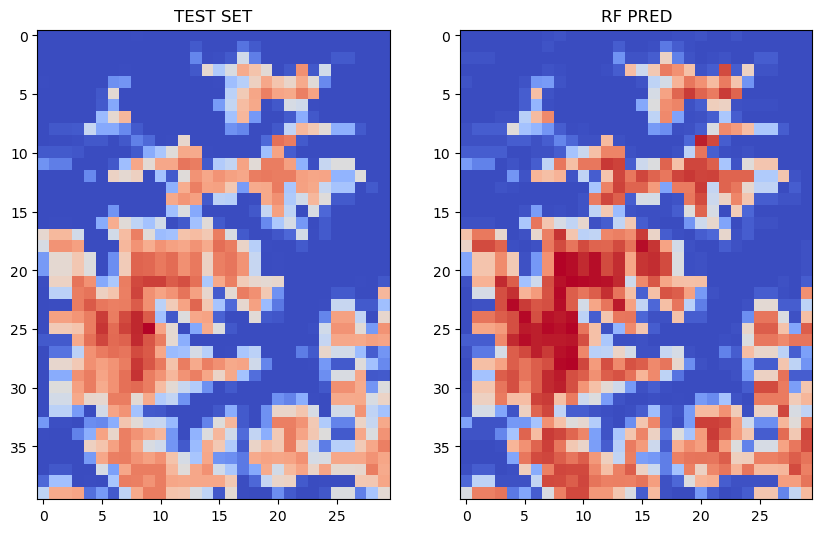

In [7]:
# Predict on the test set
RF_ = True
SVM_ = False
if RF_:
    #predicting with RF
    y_test = np.array(y_test)
    y_pred_rf = rf.predict(X_test)
    y_test_plot = np.reshape(y_test,(int(vertical_pixels),int(horizontal_pixels)))
    y_pred_plot_rf = np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels)))
    print(y_pred_plot_rf.shape)
    print(y_test_plot.shape)

if SVM_:
    #Predicting with SVM
    y_test = np.array(y_test)
    y_pred_svm = svm_lin.predict(X_test)
    y_test_plot = np.reshape(y_test,(int(vertical_pixels),int(horizontal_pixels)))
    y_pred_plot_svm = np.reshape(y_pred_svm,(int(vertical_pixels),int(horizontal_pixels)))
    print(y_pred_plot_svm.shape)
    print(y_test_plot.shape)

import matplotlib.cm as cm
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
# ax1.imshow(y_test_plot, interpolation='nearest', cmap=cm.Greys_r) #For GoL
ax1.imshow(y_test_plot, interpolation='nearest', cmap=cm.coolwarm) #For Forest Fire
ax1.set_title('TEST SET')

# ax2 = fig.add_subplot(11)
# # 'nearest' interpolation - faithful but blocky
# # ax2.imshow(y_pred_plot_svm, interpolation='nearest', cmap=cm.Greys_r) #For GoL
# # ax2.imshow(y_pred_plot_rf, interpolation='nearest', cmap=cm.coolwarm) #For Forest Fire
# # ax2.set_title('SVM PRED')

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
# ax2.imshow(y_pred_plot_rf, interpolation='nearest', cmap=cm.Greys_r) #For GoL
ax2.imshow(y_pred_plot_rf, interpolation='nearest', cmap=cm.coolwarm) #For Forest Fire
ax2.set_title('RF PRED')

plt.show()

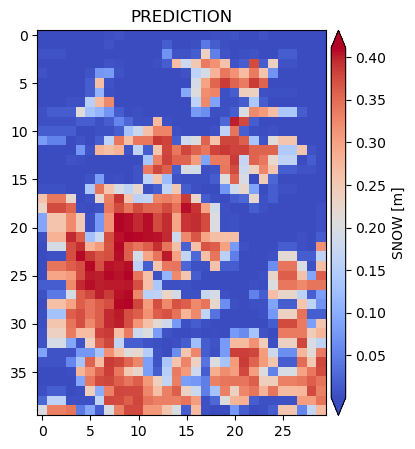

In [9]:
# import libraries needed
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
import matplotlib.cm as cm

# Seperate plots for Snowmelt one step prediction.
# Create figure for animation
fig, ax = plt.subplots(figsize=(5,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# cmap = cm.gist_yarg
cmap=cm.coolwarm

# these outer values ( vmin, vmax) are set because otherwise the colorbar keeps shifting values with each new image in the animation
im = ax.imshow(y_pred_plot_rf, interpolation='nearest', cmap=cmap)
ax.set_title('PREDICTION')
fig.colorbar(im, cax=cax, orientation='vertical', extend = 'both', label='SNOW [m]')

#save figure for animation
plt.plot()
plt.show()
fig.savefig('RF_PRED_SNOWMELT_ONESTEP.png')
plt.close()

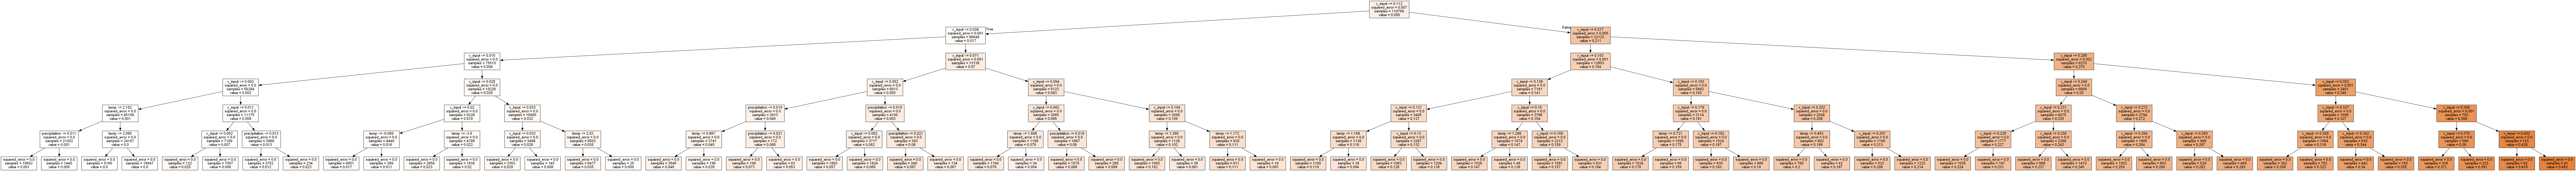

In [52]:
#The following code block represents the visualisation of a tree based model. The random forest predictor as defined above.
# tree = rf.estimators_[0]
# tree = rf.estimators_[1]
tree = rf.estimators_[2]
tree = rf.estimators_[3]
tree = rf.estimators_[4]
tree = rf.estimators_[6]
tree = rf.estimators_[7]
# tree = rf.estimators_[8]
# tree = rf.estimators_[9]
# tree = rf.estimators_[50]

# # Export as dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names = feature_names ,
                class_names = None,
                rounded = False, proportion = False,
                precision = 3, filled = True)
#
# # Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'], shell=True, cwd=os.getcwd())
#
# # # # Display in script

Image(filename = 'tree.png')

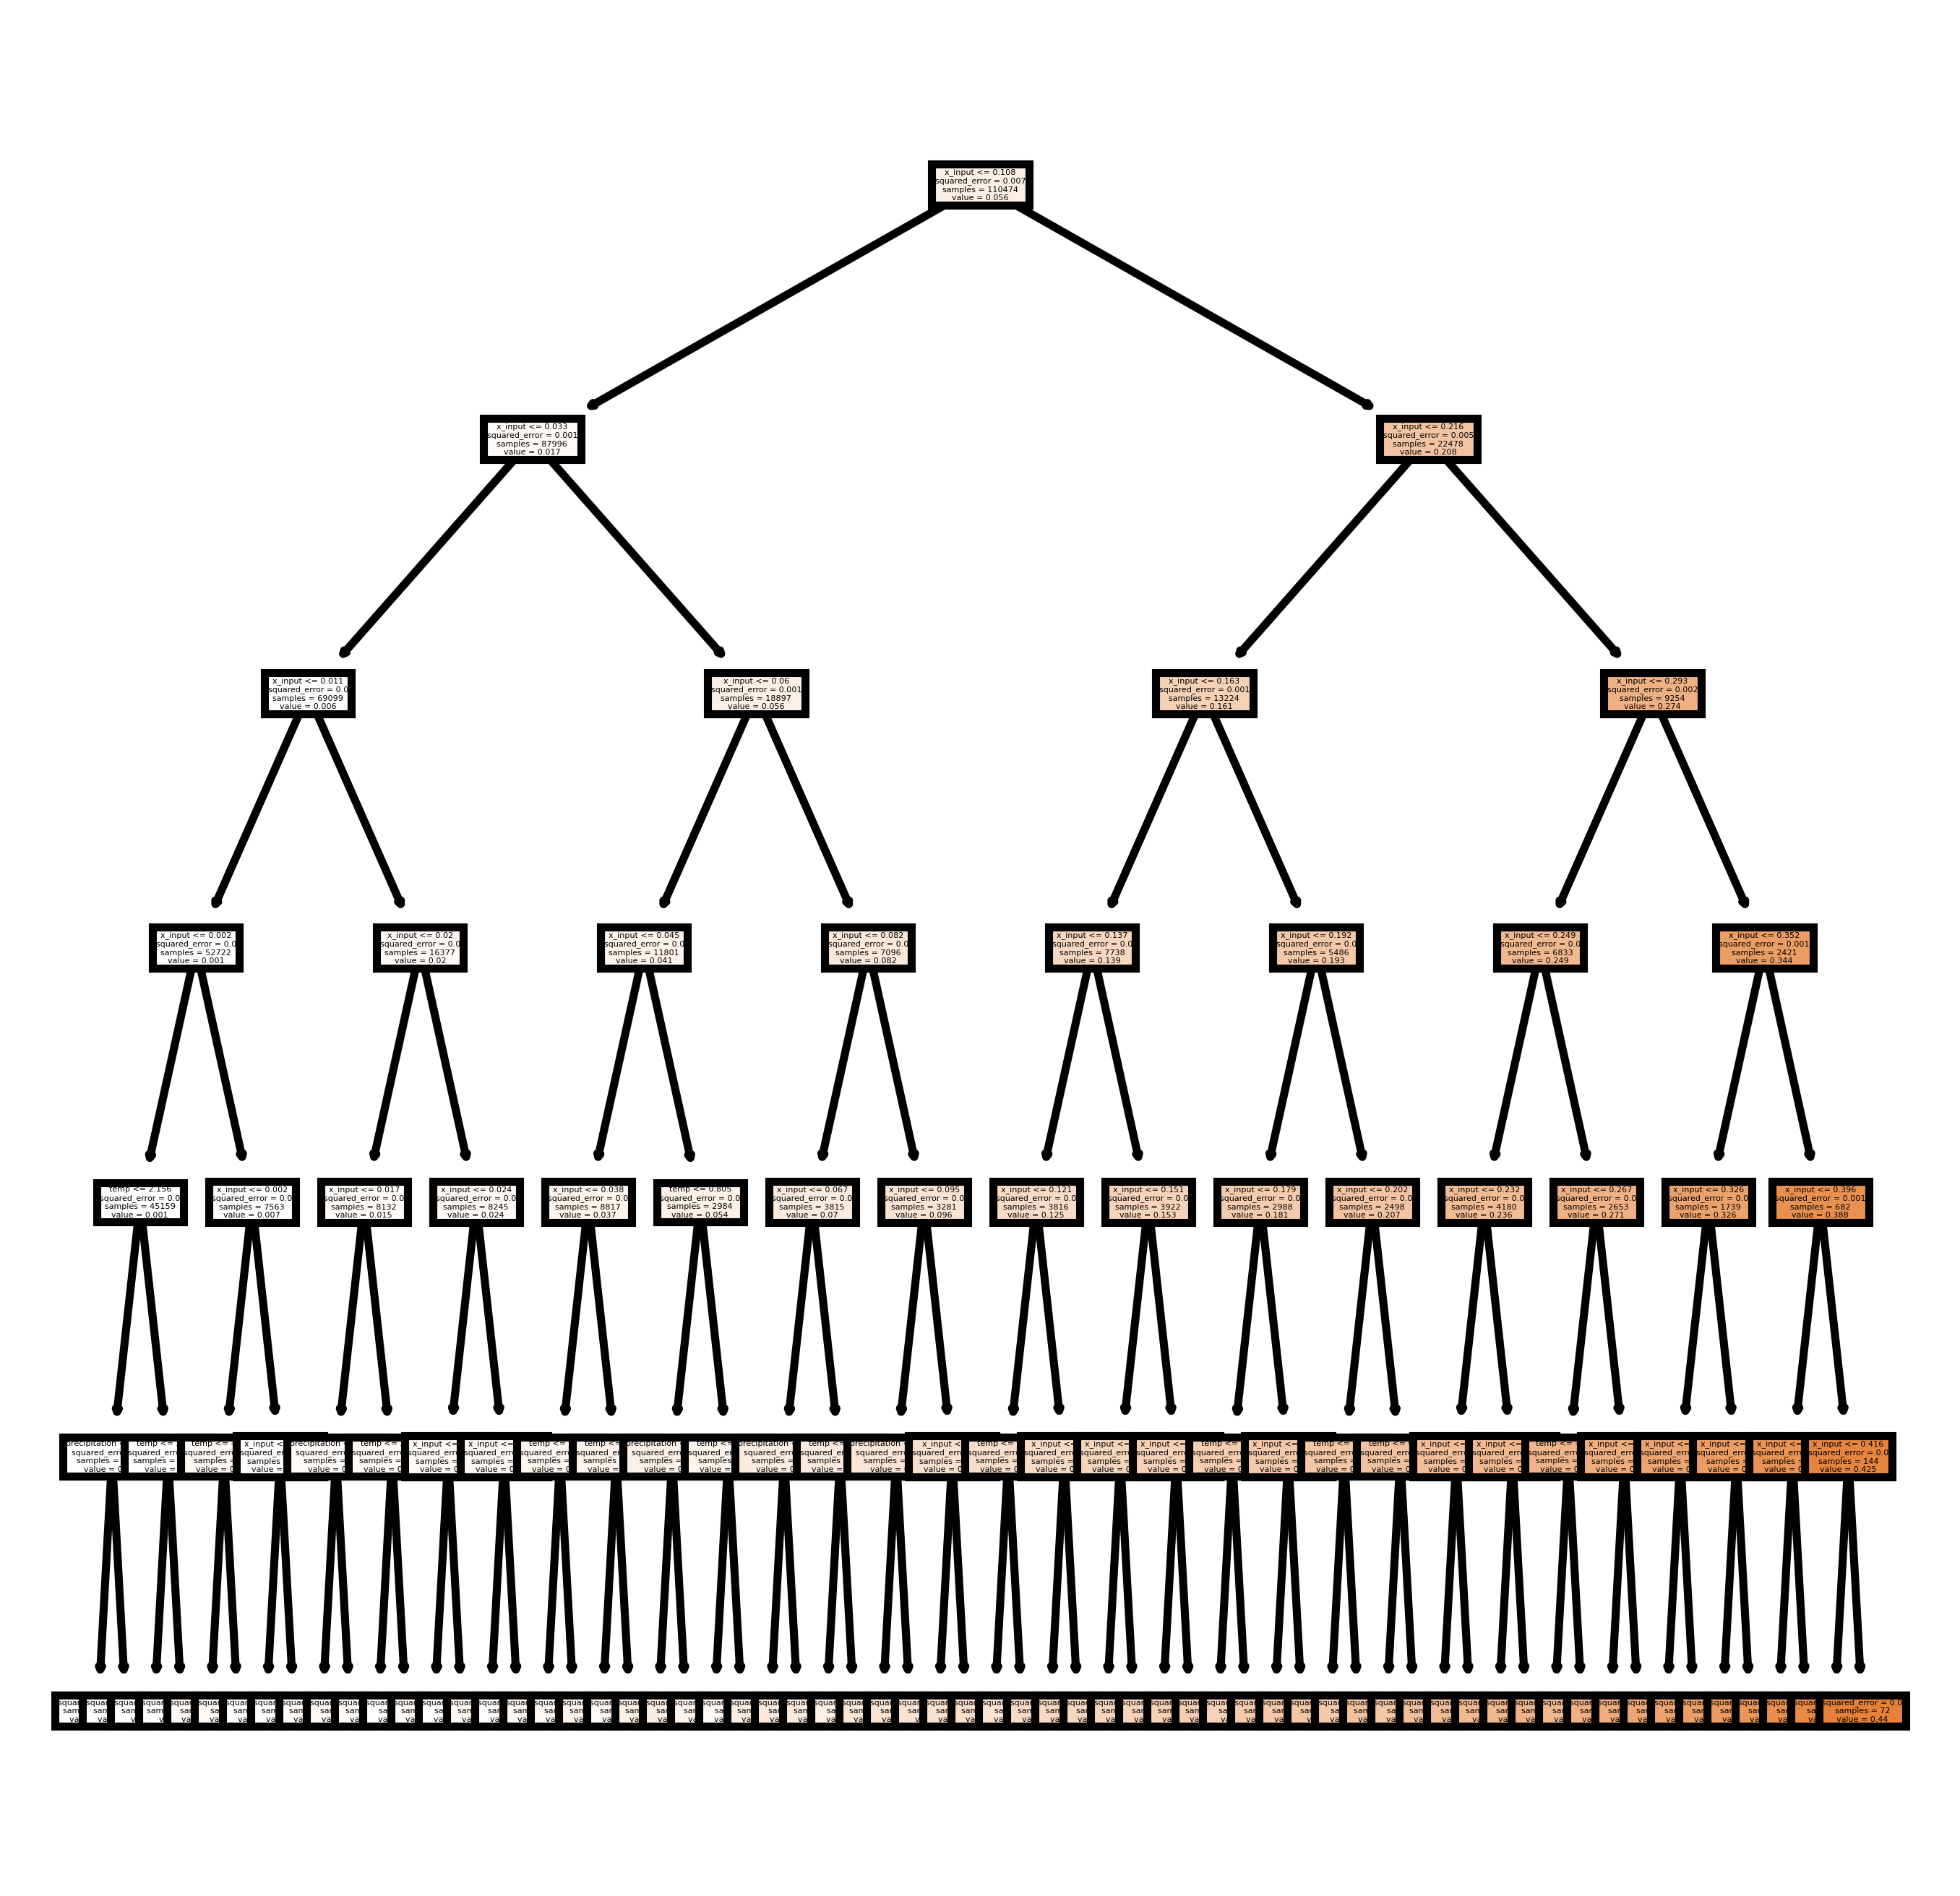

In [53]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = feature_names,
               class_names=colnames,
               filled = True);
fig.savefig('rf_individualtree.png')

# Model performance

These performance measures are based on classification simulations such as game of life and forest fires.

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score,max_error

# Mean absolute percentage error (MAPE) regression loss.
#
# Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics). Read more in the User Guide.


MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred_rf)
MAE = mean_absolute_error(y_true=y_test, y_pred = y_pred_rf)
MSE = mean_squared_error(y_true=y_test, y_pred = y_pred_rf)
MAX = max_error(y_true=y_test, y_pred = y_pred_rf)
EXPL_VAR = explained_variance_score(y_true=y_test, y_pred = y_pred_rf)

print('mean absolute percentage: ', MAPE)
print('mean absolute error: ',MAE)
print('mean squared error: ',MSE)
print('MAX ERROR: ',MAX)
print('Explained variance score: ',EXPL_VAR)


mean absolute percentage:  174593282985.37195
mean absolute error:  0.0008291584843249618
mean squared error:  2.8558456274336494e-06
MAX ERROR:  0.02062806859612465
Explained variance score:  0.9995859132681877


------------------------------------------
------------performance RF----------------
[[349   3]
 [  2  46]]
Accuracy: 0.998
------------------------------------------


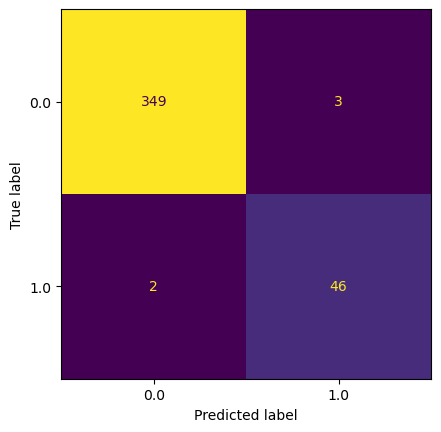

In [21]:
#check accuracy of prediction of rf
# accuracy_rf = accuracy_score(y_test[y_test!= -1], y_pred_rf[y_pred_rf!= -1])
cm_rf = confusion_matrix(y_test[y_test!= -1], y_pred_rf[y_pred_rf!= -1])

# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# cm_svm = confusion_matrix(y_test, y_pred_svm)

disp_rf =  ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
# disp_svm =  ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_lin.classes_)

disp_rf.plot(colorbar=False)
# disp_svm.plot(colorbar=False)

print('------------------------------------------')
print('------------performance RF----------------')
print(cm_rf)
print("Accuracy:", round(accuracy_rf, 3))
print('------------------------------------------')
# print('------------performance SVM---------------')
# print(cm_svm)
# print("Accuracy:", round(accuracy_svm, 3))
# print('------------------------------------------')

In [15]:
y_test

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Here will come some performance measures for regression simulation models with continuous outcomes. Such as the std RMSE and absolute error

# Visualisation of models decisions

The following code block represents the visualisation of a tree based model. The random forest predictor as defined above.

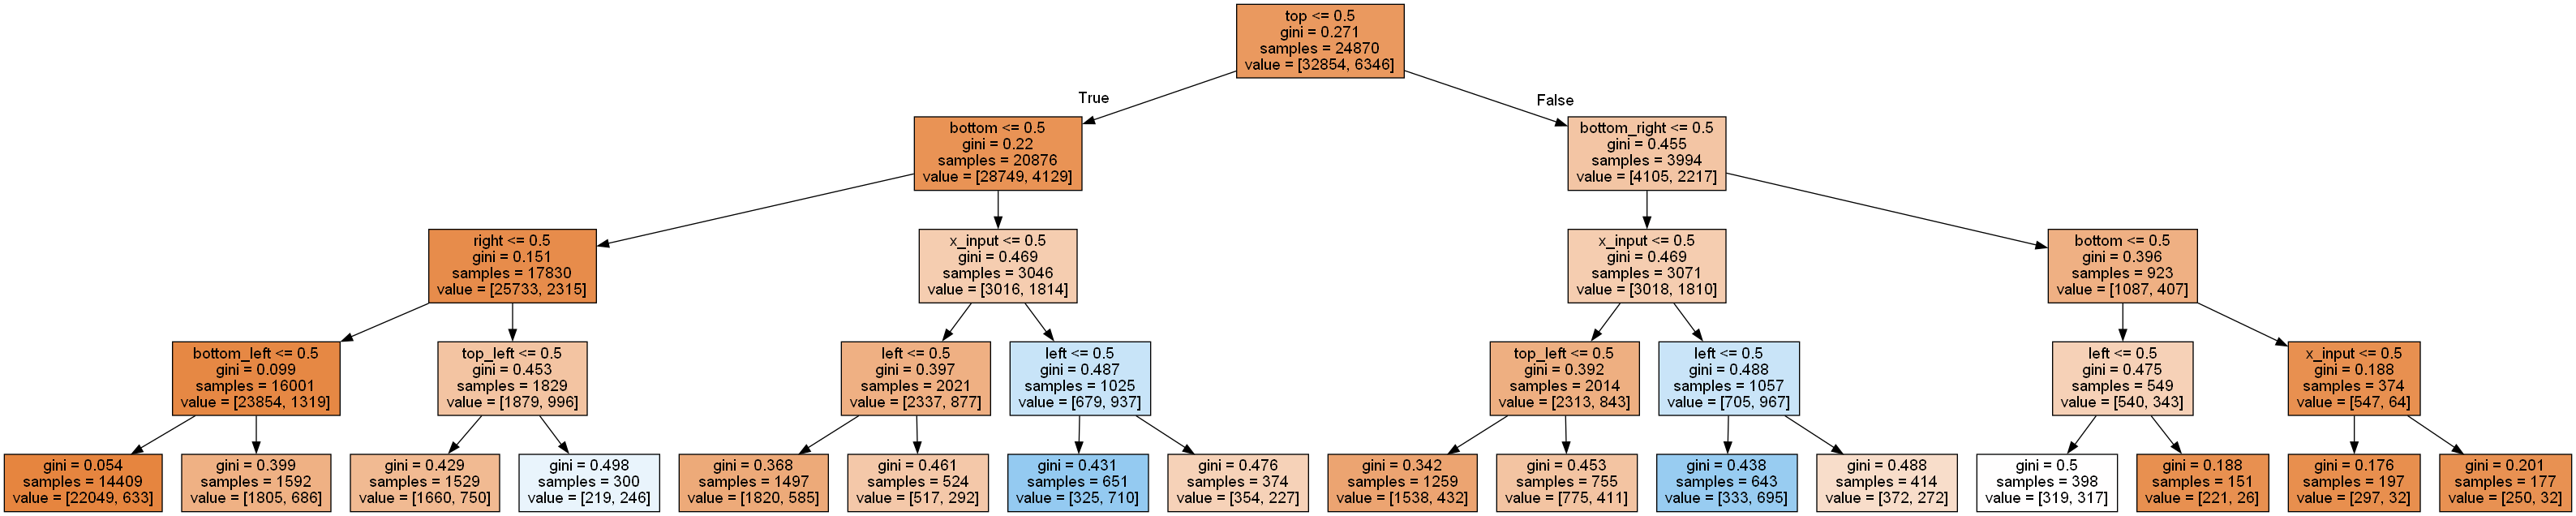

In [106]:
#
tree = rf.estimators_[1]
# tree = rf.estimators_[50]
# # Export as dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names = feature_names ,
                class_names = None,
                rounded = False, proportion = False,
                precision = 3, filled = True)
#
# # Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'], shell=True, cwd=os.getcwd())
#
# # # # Display in script

Image(filename = 'tree.png')